## Random Forest

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os
import numpy as np

#### Initialising

In [11]:
# initialising WandB
import wandb, os

os.environ["WANDB_API_KEY"] = "e84d2e19bd2cc42ec6e5d232cd0b6f0fe41f2189"
os.environ["WANDB_NOTEBOOK_NAME"] = "randomforest_models.ipynb"

In [19]:
# Load the data
data = pd.read_csv('/Users/kirst/Downloads/uvf.csv', parse_dates=['time'])

#assert len(data.columns)==23
print(data.columns)

Index(['time', 'flag', 'u_0', 'v_0', 'u_1', 'v_1', 'u_2', 'v_2', 'u_3', 'v_3',
       'u_4', 'v_4', 'u_5', 'v_5', 'u_6', 'v_6', 'u_7', 'v_7', 'u_8', 'v_8',
       'pres', 'time_of_day', 'day_of_year'],
      dtype='object')


In [20]:
# Convert "time" column to datetime format
#data['time'] = pd.to_datetime(data['time'], format='%d/%m/%Y %H:%M')

# Split the data into training and testing sets based on the date
train_data = data[(data['time'].dt.year >= 2017) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2022)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}")

training_date_range = "2017-01-01 to 2019-12-31"
testing_date_range = "2020-01-01 to 2022-12-31"

# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Check the size of the training and testing sets
len(train_data), len(test_data)

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_test = y_test.dropna()

X_train = X_train.loc[y_train.index]
X_test = X_test.loc[y_test.index]

Train range: 2017-01-01 00:01:00 -> 2019-12-30 09:39:00
Test range: 2020-01-01 22:21:00 -> 2022-12-31 21:57:00


### Optimising max_depth

In [7]:
# exploring max_depth parameter

# List of max_depth values to try
max_depth_values = [1, 3, 5, 6, 7, 8, 9, 10, 12, 15, 20]

train_precisions_values = []
test_precisions_values = []
difference_values = []


directory = './results'
file_path = os.path.join(directory, 'max_depth_results.csv')

# creating csv file to store results - allows for easy plotting/analysis
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # adding header
    writer.writerow(['Max Depth', 'Training Precision', 'Testing Precision', 'Difference'])

    for max_depth in max_depth_values:
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42, bootstrap=False)
        rf_model.fit(X_train, y_train)

        # making predictions on test/train sets
        y_pred_test = rf_model.predict(X_test)
        y_pred_train = rf_model.predict(X_train)

        # calculating precision of testing/training sets
        test_precision = precision_score(y_test, y_pred_test)
        train_precision = precision_score(y_train, y_pred_train)
        difference = abs(train_precision-test_precision)


        train_precisions_values.append(train_precision)
        test_precisions_values.append(test_precision)
        difference_values.append(difference)

        writer.writerow([max_depth, train_precision, test_precision, difference])

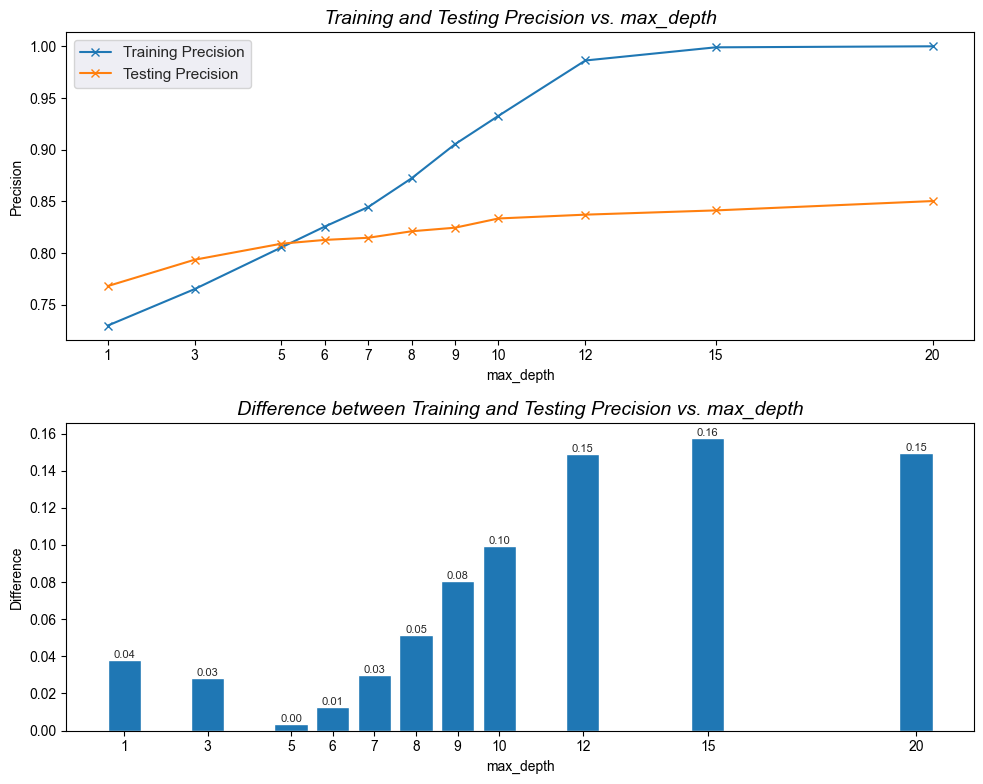

In [8]:
# reading in results
results = pd.read_csv('results/max_depth_results.csv')

# plotting
fig, axs = plt.subplots(2,1, figsize=(10, 8))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

# line plot of precision vs. max_depth (training and testing)
axs[0].plot(results['Max Depth'], results['Training Precision'], label='Training Precision', marker='x')
axs[0].plot(results['Max Depth'], results['Testing Precision'], label='Testing Precision', marker='x')
axs[0].set_xlabel('max_depth')
axs[0].set_xticks(results['Max Depth'])
axs[0].set_xticklabels(results['Max Depth'].astype(int))
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].set_title('Training and Testing Precision vs. max_depth', fontstyle='italic', fontsize=14)

# bar chart of difference between training and testing precision
axs[1].bar(results['Max Depth'], results['Difference'])

# Add data labels to the bar chart
for i, v in zip(results['Max Depth'], results['Difference']):
    axs[1].text(i, v, f"{v:.2f}", fontsize=8, ha='center', va='bottom')

axs[1].set_xlabel('max_depth')
axs[1].set_xticks(results['Max Depth'])
axs[1].set_xticklabels(results['Max Depth'].astype(int))

axs[1].set_ylabel('Difference')
axs[1].set_title('Difference between Training and Testing Precision vs. max_depth', fontstyle='italic', fontsize=14)

fig.tight_layout()

### RF Model

#### Original

In [ ]:
rf_classifier = RandomForestClassifier()
params = rf_classifier.get_params()

print(params)

In [95]:
# ORIGINAL MODEL
# wandb.init(project="MSciProject")

# Initialize the Random Forest model
rf_model1 = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=42, bootstrap=False, min_samples_split=5)

# Train the model
rf_model1.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred_rf_test = rf_model1.predict(X_test)

# making predictions on test data to check model fitting
y_pred_rf_train = rf_model1.predict(X_train)

print(y_pred_rf_test)

# calculating precision of testing/training sets
precision_test = precision_score(y_test, y_pred_rf_test)
precision_train = precision_score(y_train, y_pred_rf_train)

# Print the precision split results
print(f"Precision on Training Set = {precision_train:.3f}")
#print(f"Precision on Testing Set = {precision_test:.3f}")


# Calculate the performance metrics
accuracy = accuracy_score(y_test, y_pred_rf_test)
precision = precision_score(y_test, y_pred_rf_test)
f1 = f1_score(y_test, y_pred_rf_test)
recall = recall_score(y_test, y_pred_rf_test)
auc_roc = roc_auc_score(y_test, y_pred_rf_test)

#auc_pr
precision1, recall1, _ = precision_recall_curve(y_test, y_pred_rf_test)
auc_pr = auc(recall1, precision1)

#specificity
threshold = 0.5
# Convert predicted probabilities to binary predictions using the threshold
y_pred_binary = (y_pred_rf_test > threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)


#print(f"Model accuracy = {accuracy:.3f}")
print(f"Model precision = {precision:.3f}")
#print(f"Model recall = {recall:.3f}")
#print(f"Model auc_roc = {auc_roc:.3f}")
#print(f"Model f1 score = {f1:.3f}")
#print(f"Model auc_pr = {auc_pr:.3f}")
#print(f"Model specificity = {specificity:.3f}")


# wandb.log({"model_name":"Random Forest (Balanced Data), bootstrap=false", "accuracy":accuracy, "precision":precision, "recall":recall, 
        #    "auc_roc":auc_roc, "f1_score":f1, "auc_pr":auc_pr, "specificity":specificity,
        #    "training date range": training_date_range, "testing date range": testing_date_range})

# wandb.finish()

[1. 1. 1. ... 1. 1. 1.]
Precision on Training Set = 0.897
Model precision = 0.830


#### Using Confidence Threshold

##### Plots

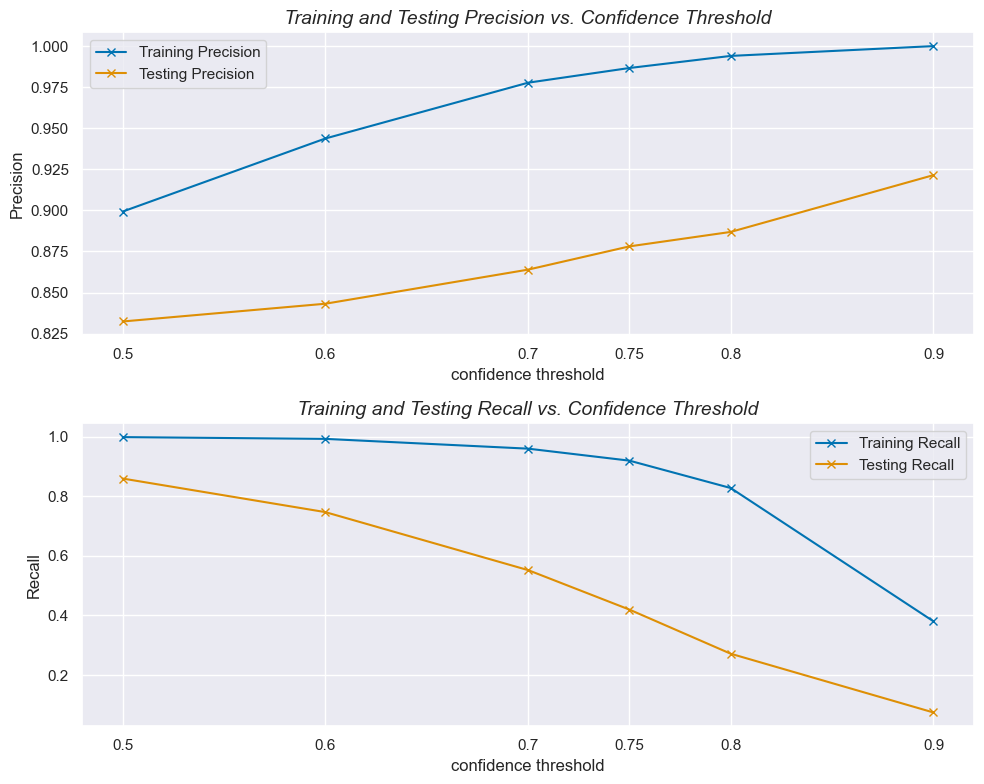

In [28]:
# exploring confidence threshold parameter

# List of max_depth values to try
confidence_threshold_vals = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9]

train_precisions_values = []
test_precisions_values = []
difference_values = []

directory = './results'
file_path = os.path.join(directory, 'threshold_results.csv')

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # adding header
    writer.writerow(['Confidence Threshold', 'Training Precision', 'Testing Precision', 'Training Recall', 'Testing Recall'])

    for threshold in confidence_threshold_vals:
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=42, bootstrap=False)
        rf_model.fit(X_train, y_train)

        class_probabilities_test = rf_model.predict_proba(X_test)
        class_probabilites_train = rf_model.predict_proba(X_train)
        
        # make predictions based on threshold
        y_pred_rf_test_threshold = (class_probabilities_test[:, 1] >= threshold).astype(int)
        y_pred_rf_train_threshold = (class_probabilites_train[:, 1] >= threshold).astype(int)

        # calculating precision of testing/training sets
        test_precision = precision_score(y_test, y_pred_rf_test_threshold)
        train_precision = precision_score(y_train, y_pred_rf_train_threshold)

        # calculating recall
        test_recall = recall_score(y_test, y_pred_rf_test_threshold)
        train_recall = recall_score(y_train, y_pred_rf_train_threshold)

        train_precisions_values.append(train_precision)
        test_precisions_values.append(test_precision)
        difference_values.append(difference)

        writer.writerow([threshold, train_precision, test_precision, train_recall, test_recall])

# reading in results
results = pd.read_csv('results/threshold_results.csv')

# plotting
fig, axs = plt.subplots(2,1, figsize=(10, 8))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

# line plot of precision vs. max_depth (training and testing)
axs[0].plot(results['Confidence Threshold'], results['Training Precision'], label='Training Precision', marker='x')
axs[0].plot(results['Confidence Threshold'], results['Testing Precision'], label='Testing Precision', marker='x')
axs[0].set_xlabel('confidence threshold')
axs[0].set_xticks(results['Confidence Threshold'])
axs[0].set_xticklabels(results['Confidence Threshold'])
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].set_title('Training and Testing Precision vs. Confidence Threshold', fontstyle='italic', fontsize=14)

# line plot of recall vs. max_depth (training and testing)
axs[1].plot(results['Confidence Threshold'], results['Training Recall'], label='Training Recall', marker='x')
axs[1].plot(results['Confidence Threshold'], results['Testing Recall'], label='Testing Recall', marker='x')
axs[1].set_xlabel('confidence threshold')
axs[1].set_xticks(results['Confidence Threshold'])
axs[1].set_xticklabels(results['Confidence Threshold'])
axs[1].set_ylabel('Recall')
axs[1].legend()
axs[1].set_title('Training and Testing Recall vs. Confidence Threshold', fontstyle='italic', fontsize=14)

fig.tight_layout()

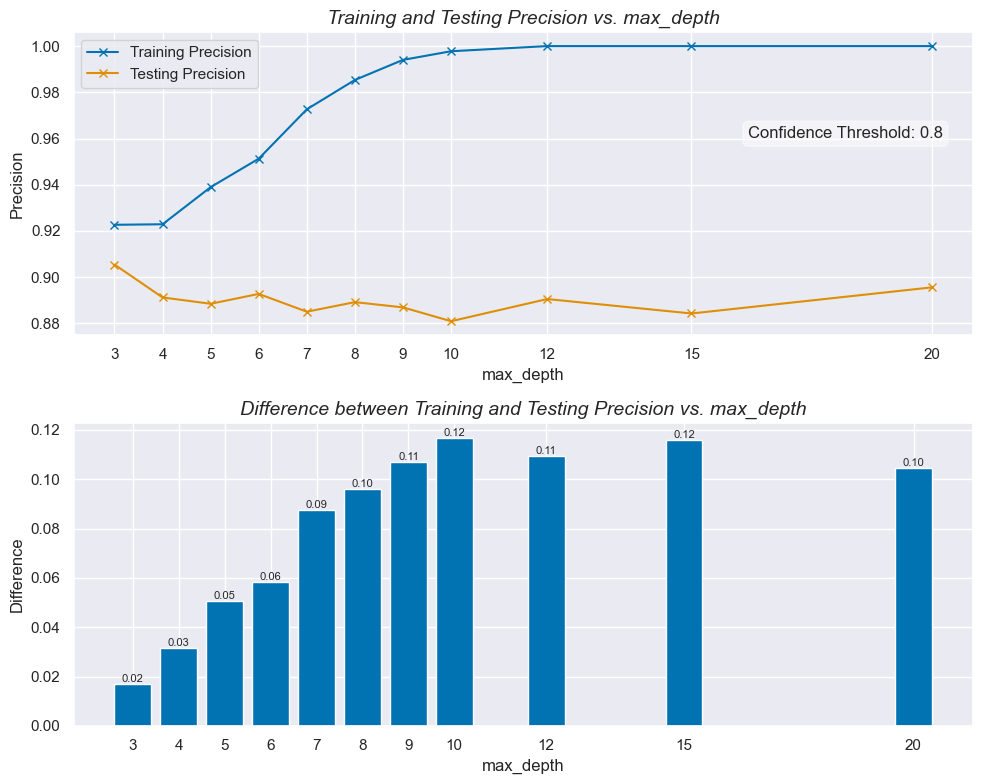

In [55]:
# exploring max_depth parameter

# List of max_depth values to try
max_depth_values = [3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]

train_precisions_values = []
test_precisions_values = []
difference_values = []

directory = './results'
file_path = os.path.join(directory, 'max_depth_threshold.csv')

# Open the file and write the results
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Rest of the code...
    writer = csv.writer(file)
    
    # adding header
    writer.writerow(['Max Depth', 'Training Precision', 'Testing Precision', 'Difference'])

    for max_depth in max_depth_values:
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42, bootstrap=False)
        rf_model.fit(X_train, y_train)

        class_probabilities_test = rf_model.predict_proba(X_test)
        class_probabilites_train = rf_model.predict_proba(X_train)

        threshold = 0.8
        
        # make predictions based on threshold
        y_pred_rf_test_threshold = (class_probabilities_test[:, 1] >= threshold).astype(int)
        y_pred_rf_train_threshold = (class_probabilites_train[:, 1] >= threshold).astype(int)

        # calculating precision of testing/training sets
        test_precision = precision_score(y_test, y_pred_rf_test_threshold)
        train_precision = precision_score(y_train, y_pred_rf_train_threshold)
        difference = abs(train_precision-test_precision)

        train_precisions_values.append(train_precision)
        test_precisions_values.append(test_precision)
        difference_values.append(difference)

        writer.writerow([max_depth, train_precision, test_precision, difference])


# reading in results
results = pd.read_csv('results/max_depth_threshold.csv')

# plotting
fig, axs = plt.subplots(2,1, figsize=(10, 8))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

# line plot of precision vs. max_depth (training and testing)
axs[0].plot(results['Max Depth'], results['Training Precision'], label='Training Precision', marker='x')
axs[0].plot(results['Max Depth'], results['Testing Precision'], label='Testing Precision', marker='x')
axs[0].set_xlabel('max_depth')
axs[0].set_xticks(results['Max Depth'])
axs[0].set_xticklabels(results['Max Depth'].astype(int))
axs[0].set_ylabel('Precision')
axs[0].legend()
axs[0].set_title('Training and Testing Precision vs. max_depth', fontstyle='italic', fontsize=14)

# bar chart of difference between training and testing precision
axs[1].bar(results['Max Depth'], results['Difference'])

# Add data labels to the bar chart
for i, v in zip(results['Max Depth'], results['Difference']):
    axs[1].text(i, v, f"{v:.2f}", fontsize=8, ha='center', va='bottom')

axs[1].set_xlabel('max_depth')
axs[1].set_xticks(results['Max Depth'])
axs[1].set_xticklabels(results['Max Depth'].astype(int))

axs[1].set_ylabel('Difference')
axs[1].set_title('Difference between Training and Testing Precision vs. max_depth', fontstyle='italic', fontsize=14)


# adding confidence threshold to plot
text_box = f'Confidence Threshold: {threshold}'

axs[0].text(0.75, 0.65, text_box, transform=axs[0].transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


fig.tight_layout()

##### Algorithm

In [27]:
# CLASS PROBABILITIES MODEL
#wandb.init(project="MSciProject")

rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42, 
                                  bootstrap=False, min_samples_split=5)

rf_model.fit(X_train, y_train)

# finding class probabilities for each sample
class_probabilities_test = rf_model.predict_proba(X_test)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = 0.8

# make predictions based on threshold
y_pred_rf_test_threshold = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)
y_pred_rf_train_threshold = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)

print(y_pred_rf_test_threshold)
print(np.count_nonzero(y_pred_rf_train_threshold == 1))

# Calculate precision for testing and training sets
precision_test_threshold = precision_score(y_test, y_pred_rf_test_threshold)
precision_train_threshold = precision_score(y_train, y_pred_rf_train_threshold)

# Print precision results
print(f"Precision on Training Set (with threshold) = {precision_train_threshold:.4f}")
print(f"Precision on Testing Set (with threshold) = {precision_test_threshold:.4f}")

# Calculate other performance metrics for testing set
accuracy = accuracy_score(y_test, y_pred_rf_test_threshold)
precision = precision_score(y_test, y_pred_rf_test_threshold)
f1 = f1_score(y_test, y_pred_rf_test_threshold)
recall = recall_score(y_test, y_pred_rf_test_threshold)
auc_roc = roc_auc_score(y_test, y_pred_rf_test_threshold)

# Calculate precision-recall curve and AUC-PR for testing set
precision1, recall1, _ = precision_recall_curve(y_test, y_pred_rf_test_threshold)
auc_pr = auc(recall1, precision1)

# Calculate specificity for testing set
threshold = 0.5
y_pred_binary_threshold = (y_pred_rf_test_threshold > threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary_threshold)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn/(tn+fp)

# Print other performance metrics for testing set
print(f"Model accuracy (with threshold) = {accuracy:.4f}")
print(f"Model precision (with threshold) = {precision:.4f}")
print(f"Model recall (with threshold) = {recall:.4f}")
print(f"Model auc_roc (with threshold) = {auc_roc:.4f}")
print(f"Model f1 score (with threshold) = {f1:.4f}")
print(f"Model auc_pr (with threshold) = {auc_pr:.4f}")
print(f"Model specificity (with threshold) = {specificity:.4f}")


# wandb.log({"model_name":"Random Forest (Balanced Data), bootstrap=false", "accuracy":accuracy, "precision":precision, "recall":recall, 
            # "auc_roc":auc_roc, "f1_score":f1, "auc_pr":auc_pr, "specificity":specificity,
            # "training date range": training_date_range, "testing date range": testing_date_range})

# wandb.finish()

[0 1 1 ... 0 0 0]
774
Precision on Training Set (with threshold) = 0.9315
Precision on Testing Set (with threshold) = 0.8936
Model accuracy (with threshold) = 0.4533
Model precision (with threshold) = 0.8936
Model recall (with threshold) = 0.2482
Model auc_roc (with threshold) = 0.5897
Model f1 score (with threshold) = 0.3885
Model auc_pr (with threshold) = 0.8339
Model specificity (with threshold) = 0.9312


In [22]:
# Save the model
dump(rf_model, '/Users/kirst/Downloads/rf_model.joblib')

['/Users/kirst/Downloads/rf_model.joblib']

### Optimising Hyperparameters

In [ ]:
rf_classifier = RandomForestClassifier()
params = rf_classifier.get_params()

print(params)

In [ ]:
#wandb.init(project="MSciProject")

# Define the hyperparameters to search over
'''
INITIAL GRID
param_grid = {'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']}
'''
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap' : [True, False]
}


# Initialize the grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best recall score
best_params = grid_search.best_params_
best_recall = grid_search.best_score_

best_params, best_recall

#wandb.log({"model_name":"Random Forest Grid Search", "Best Parameters": best_params, "Best Recall": best_recall})

### Optimised Model

In [ ]:
wandb.init(project="MSciProject")

# Run model with best parameters
# try this against gradient boosted tree and compare?

rf_model = RandomForestClassifier(random_state=42,
                                  max_depth=20,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  n_estimators=200,
                                  bootstrap=False)


rf_model.fit(X_train, y_train)

# Use the model to make predictions on the test data
y_pred = rf_model.predict(X_test)

# Calculate the performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#auc_pr
precision1, recall1, _ = precision_recall_curve(y_test, y_pred)
auc_pr = auc(recall1, precision1)

#specificity
threshold = 0.5
# Convert predicted probabilities to binary predictions using the threshold
y_pred_binary = (y_pred > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)
tn, fp, fn, tp = conf_matrix.ravel()

specificity = tn / (tn + fp)

accuracy, precision, recall, auc_roc, f1, auc_pr, specificity

wandb.log({"model_name":"Final Random Forest, bootstrap=False", "accuracy":accuracy, "precision":precision, 
           "recall":recall, "auc_roc":auc_roc, "f1_score":f1, "auc_pr":auc_pr, "specificity":specificity,
           "training date range": training_date_range, "testing date range": testing_date_range })

wandb.finish()

In [ ]:
# Save the model
dump(rf_model, '/Users/kirst/Downloads/rf_model.joblib')